In [191]:
import mediapipe as mp
import numpy as np
import cv2
import math
import pandas as pd
import time
import os 
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

Flow Detection:

- Gambar Raw Orang lagi mengemudi 

- Gambar ROI Wajah 

- Gambar ROI Wajah yang di extract face landmark Mediapipe (hanya bagian mata), label titik landmark sesuaikan dengan rumus 

In [192]:
work_dir = 'C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata'

eye_open = f'{work_dir}/Datasets/Documentation/mata_terbuka.jpg'
eye_close = f'{work_dir}/Datasets/Documentation/mata_tertutup.jpg'

In [193]:
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

facemesh =  mp.solutions.face_mesh
face = facemesh.FaceMesh(
    static_image_mode=False, 
    min_tracking_confidence=0.5, 
    min_detection_confidence=0.5
    )
draw = mp.solutions.drawing_utils

In [227]:

def calculate_font_parameters(frame, base_font_scale=0.002, base_thickness=0.005):
    frame_height, frame_width = frame.shape[:2]
    font_scale = frame_height * base_font_scale
    thickness = int(frame_height * base_thickness)
    
    return font_scale, thickness

def putText(frame, val, x, y, unity=""):
    font_scale, thickness = calculate_font_parameters(frame, 0.0015, 0.005)
    
    if len(unity) == 0:
        text = f'{val}'
    else:
        text = f'{val:.3f} {unity}'
        
    cv2.putText(frame, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)
        
                
def getTargettedLandmark():
    targetted_landmark = []
    targetted_landmark.append(chosen_left_eye_idxs)
    targetted_landmark.append(chosen_right_eye_idxs)
    return targetted_landmark   

def drawEyeText(frame, val, x, w, y, h):
    font_scale, thickness = calculate_font_parameters(frame, 0.001, 0.003)
    
    cv2.putText(
        frame, text=f'p{val}', org=(int(x * w), int(y * h)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, color=(0, 0, 255),
        thickness=thickness, lineType=cv2.LINE_AA
    )

def eucDist(point1, point2):
    return math.sqrt((point2.x - point1.x)**2 + (point2.y - point1.y)**2)

def eyeAspectRatio(right_eye, left_eye):
    right_eye = (eucDist(right_eye[2], right_eye[5]) + eucDist(right_eye[4], right_eye[3]))/(2*eucDist(right_eye[0], right_eye[1]))
    left_eye = (eucDist(left_eye[4], left_eye[3]) + eucDist(left_eye[5], left_eye[2]))/(2*eucDist(left_eye[1], left_eye[0]))
    return right_eye, left_eye

def eyeAnalysis(right_eye, left_eye):
    thresh_ear = 0.29
    eye_status = None
    avgEAR = (left_eye + right_eye) / 2
    # if(right_eye < thresh_ear and left_eye < thresh_ear):
    if avgEAR < thresh_ear:
        # ear_msg = f'! Drowsiness Detected ! - EAR Score : {str(avgEAR)}'
        # print(ear_msg)
        eye_status = 'Eye Closed'
    else: 
        eye_status = 'Eye Opened'
    return eye_status

def detect_drowsiness(image_array):
    mp_face_mesh = mp.solutions.face_mesh
    face = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

    image = image_array.copy()
    img_h, img_w, _ = image.shape
    op = face.process(image)

    if op.multi_face_landmarks:
        for pt in op.multi_face_landmarks:
            eye_store = [[], []]
            left_eye, right_eye, mouth, head = [1, 1, 1, 1]
            eye_status = None
                    
            for no, point in enumerate(pt.landmark):
                if no in chosen_left_eye_idxs:
                    drawEyeText(image, left_eye, point.x, img_w, point.y, img_h)
                    eye_store[0].append(point)
                    left_eye += 1
                if no in chosen_right_eye_idxs:
                    drawEyeText(image, right_eye, point.x, img_w, point.y, img_h)
                    eye_store[1].append(point)
                    right_eye += 1
                    
            if len(eye_store[0]) > 1:
                right_eye, left_eye = eyeAspectRatio(eye_store[0], eye_store[1])
                
            avg_ear = (right_eye + left_eye) / 2 
            putText(image, left_eye, 5, 60, "left")
            putText(image, right_eye, 5, 120, "right")
            putText(image, avg_ear, 5, 180, "avg")
            
            eye_status = eyeAnalysis(right_eye, left_eye)
            putText(image, f'pred: {eye_status}', 5, img_h-50)
        
        print(f'Result: {avg_ear} - {eye_status}')
        return image
        # plt.imshow(image)
        # plt.axis('off')
        # # plt.title(f'{eye_status}')
        # plt.title('Hasil Deteksi')
        # plt.show()

In [224]:
def check_and_create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory {path} created.")
    else:
        print(f"Directory {path} already exists.")
        
def resize_image(image, target_width):
    h, w, _ = image.shape
    scale = target_width / w
    new_width = target_width
    new_height = int(h * scale)
    
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_image

def detect_drowsiness_flow(image_path, save_dir, target_width=5000):
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Gambar {image_path} tidak ditemukan.")
        return None

    # Resize gambar secara proporsional
    image = resize_image(image, target_width)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_roi = image_rgb.copy()
    roi_images = None

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                # Memastikan bahwa koordinat ROI tetap berada dalam batas gambar yang baru diresize
                x = max(0, x)
                y = max(0, y)
                w = min(iw - x, w)
                h = min(ih - y, h)
                
                cv2.rectangle(image_with_roi, (x, y), (x + w, y + h), (0, 255, 0), 50)
                
                roi_image = image_rgb[y:y+h, x:x+w]
                roi_images = roi_image
    
    
    if roi_images is not None:
        image_result = detect_drowsiness(roi_images)
        # Set up the plot
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot the raw image
        axs[0].imshow(image_rgb)
        axs[0].set_title('Gambar Raw')
        axs[0].axis('off')
        
        # Plot the image with ROI
        axs[1].imshow(image_with_roi)
        axs[1].set_title('Gambar dengan ROI')
        axs[1].axis('off')
        
        # Plot the ROI images
        axs[2].imshow(roi_images)
        axs[2].set_title('Gambar ROI')
        axs[2].axis('off')
        
        # Plot the detection result
        axs[3].imshow(image_result)
        axs[3].set_title('Hasil Deteksi')
        axs[3].axis('off')

        # Save each subplot as a separate image
        image_names = ['Raw', 'Raw with ROI', 'ROI', 'Detection Result']
        images = [image_rgb, image_with_roi, roi_images, image_result]
        check_and_create_directory(save_dir)
        
        plt.show()
        
        for i, img in enumerate(images):
            filename = image_names[i]
            filepath = f'{save_dir}/{filename}'
            
            plt.figure()
            plt.imshow(img)
            plt.title(filename)
            plt.axis('off')
            plt.savefig(f'{filepath}.png', bbox_inches='tight', pad_inches=0)
            plt.close()

    # return roi_images

Result: 0.15781307166583144 - Eye Closed
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Documentation/Eye Close already exists.


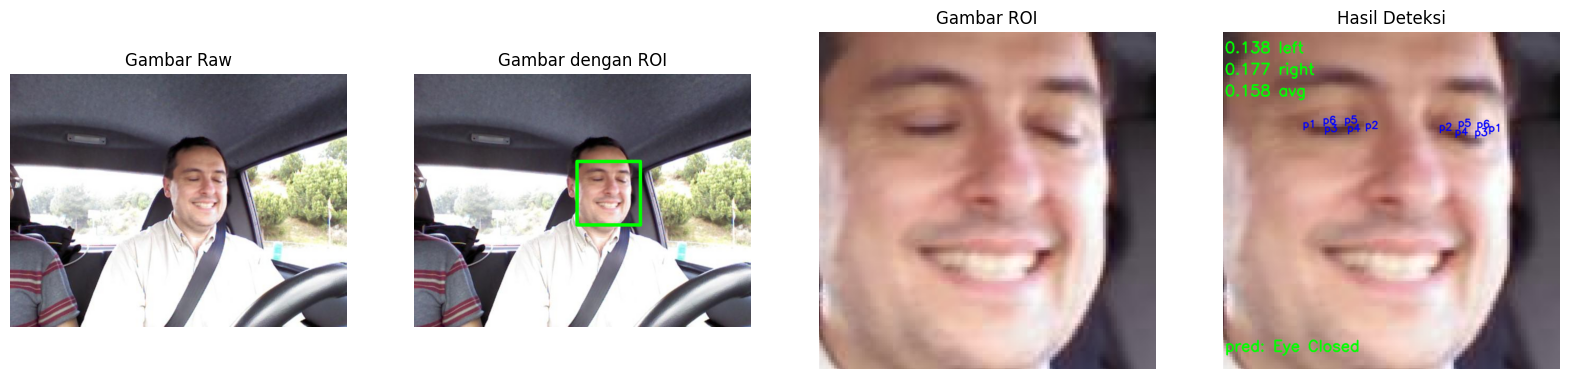

Result: 0.2775203574110905 - Eye Closed
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Documentation/Eye Open already exists.


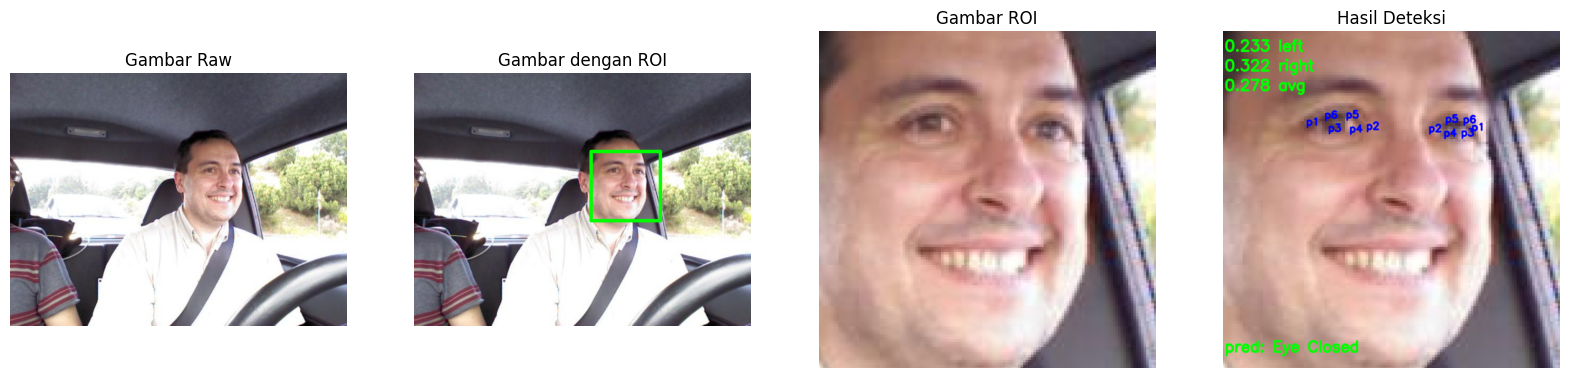

In [228]:
save_dir_close = f'{work_dir}/Annotations Result/Documentation/Eye Close'
detect_drowsiness_flow(eye_close, save_dir_close)

save_dir_open = f'{work_dir}/Annotations Result/Documentation/Eye Open'
detect_drowsiness_flow(eye_open, save_dir_open)